<a href="https://colab.research.google.com/github/Fevzierenn/Reddit-Post-Popularity-Classification-DeepLearning/blob/main/Welcome_to_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('redditMorePosts.csv')

In [3]:
df = df[['title','subreddit']]

In [4]:
df.tail(2)

,title,subreddit
10790,"India Caps Starlink Access, Protects BSNL’s Ma...",TrendoraX
10791,2.5 Meters of Ground Shift in Just 1.3 Seconds 😱,TrendoraX


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10792 entries, 0 to 10791
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      10792 non-null  object
 1   subreddit  10792 non-null  object
dtypes: object(2)
memory usage: 168.8+ KB


In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['subreddit'])

In [8]:
df.head(1)

,title,subreddit,label
0,Reports: EA set to be sold to private investor...,technology,9


In [9]:
le.classes_

array(['Daytrading', 'Jokes', 'Music', 'TrendoraX', 'USNEWS', 'funny',
       'movies', 'news', 'science', 'technology', 'worldnews'],
      dtype=object)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_texts, temp_texts,train_labels,temp_labels = train_test_split(
    df['title'],df['label'],test_size=0.3,random_state=42,stratify=df['label'])

val_texts, test_texts,val_labels,test_labels = train_test_split(
    temp_texts,temp_labels,test_size=0.5,random_state=42,stratify=temp_labels)

In [12]:
print("Train:",len(train_texts))
print("Val:",len(val_texts))
print("Test:",len(test_texts))

Train: 7554
Val: 1619
Test: 1619


In [13]:
from transformers import AutoTokenizer

In [14]:
#Bert Tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

#Encode etme
train_encodings = tokenizer(train_texts.tolist(),truncation=True,padding=True, max_length=64)
val_encodings = tokenizer(val_texts.tolist(),truncation=True,padding=True, max_length=64)
test_encodings = tokenizer(test_texts.tolist(),truncation=True,padding=True, max_length=64)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
import torch
from torch.utils.data import Dataset

In [16]:
class SubredditDataset(Dataset):
  def __init__(self,encodings,labels):
    self.encodings = encodings
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    item = {key:torch.tensor(val[idx]) for key,val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels.iloc[idx])
    return item

train_dataset = SubredditDataset(train_encodings,train_labels)
val_dataset = SubredditDataset(val_encodings,val_labels)
test_dataset = SubredditDataset(test_encodings,test_labels)

In [17]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=11)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
print(next(iter(train_dataset)))

{'input_ids': tensor([  101,   100,  4911,  1024, 10079, 11758,  2091,  2845, 24633,  2058,
         3735,  1011,  3720,  1018, 24959,  2005,  2034,  2051,  2144, 16798,
         2475,   100,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'labels'

In [25]:
from transformers import Trainer, TrainingArguments

In [26]:
#Training ayarları
training_args = TrainingArguments(
    output_dir='./results',        #modelin kaydedileceği klasor
    # evaluation_strategy = "epoch",  #her epoch sonunda validation yap.
    # save_strategy = "epoch",        #her epoch sonunda modeli kaydet
    # learning_rate=2e-5,             #Bert için ideal Learning rate
    per_device_train_batch_size=16, #batch boyutu
    per_device_eval_batch_size=16,
    num_train_epochs=10,             #epoch sayısı
    weight_decay=0.01,              #regularization
    logging_dir='./logs',           #log dosyaları
    logging_steps=200,               #her 10 adımda log yaz
    # load_best_model_at_end=True,    #validation en iyi olunca o modeli al
    metric_for_best_model="accuracy",
    report_to="none"
)

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = np.argmax(pred.predictions,axis=1)
  f1 = f1_score(labels,preds,average='macro')
  acc = accuracy_score(labels,preds)
  return {
      'accuracy':acc,
      'f1':f1
  }
#

In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1974689658.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [29]:
trainer.train()

Step,Training Loss
200,0.583900
400,0.766900
600,0.534300
800,0.432400
1000,0.352200
1200,0.213600
1400,0.228000
1600,0.119300
1800,0.118100
2000,0.091100


TrainOutput(global_step=4730, training_loss=0.16069417856712423, metrics={'train_runtime': 1073.9755, 'train_samples_per_second': 70.337, 'train_steps_per_second': 4.404, 'total_flos': 2484626900175360.0, 'train_loss': 0.16069417856712423, 'epoch': 10.0})

In [30]:
results = trainer.evaluate(test_dataset)
print("Test set performance:", results)

Test set performance: {'eval_loss': 1.4683045148849487, 'eval_accuracy': 0.7634342186534898, 'eval_f1': 0.7646767103705417, 'eval_runtime': 5.5611, 'eval_samples_per_second': 291.129, 'eval_steps_per_second': 18.342, 'epoch': 10.0}


In [31]:
logs = trainer.state.log_history

In [32]:
df_logs = pd.DataFrame(logs)
print(df_logs.head())

     loss  grad_norm  learning_rate     epoch  step  train_runtime  \
0  0.5839   9.644504       0.000048  0.422833   200            NaN   
1  0.7669  22.696880       0.000046  0.845666   400            NaN   
2  0.5343  13.036808       0.000044  1.268499   600            NaN   
3  0.4324  11.258084       0.000042  1.691332   800            NaN   
4  0.3522   3.922376       0.000039  2.114165  1000            NaN   

   train_samples_per_second  train_steps_per_second  total_flos  train_loss  \
0                       NaN                     NaN         NaN         NaN   
1                       NaN                     NaN         NaN         NaN   
2                       NaN                     NaN         NaN         NaN   
3                       NaN                     NaN         NaN         NaN   
4                       NaN                     NaN         NaN         NaN   

   eval_loss  eval_accuracy  eval_f1  eval_runtime  eval_samples_per_second  \
0        NaN            N

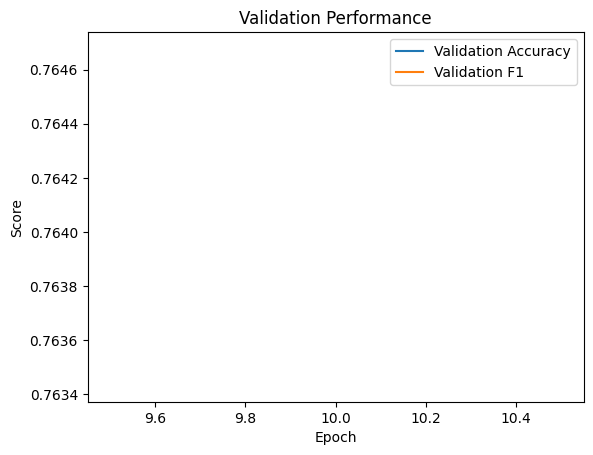

In [33]:
eval_logs = df_logs.dropna(subset = ['eval_loss'])

plt.plot(eval_logs['epoch'],eval_logs['eval_accuracy'],label='Validation Accuracy')
plt.plot(eval_logs['epoch'],eval_logs['eval_f1'],label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Performance')
plt.legend()
plt.show()

In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_path = "./results/checkpoint-4730"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [77]:
title  ="Jay-z - We the best"
inputs = tokenizer(title,return_tensors="pt", truncation=True , padding=True, max_length=64)


In [78]:
with torch.no_grad():
  outputs = model(**inputs)
  probs = torch.softmax(outputs.logits,dim=1)
  pred_label = torch.argmax(probs,dim=1).item()

In [79]:
pred_subreddit =le.inverse_transform([pred_label])[0]
print("Predicted Subreddit:",pred_subreddit)

Predicted Subreddit: Music
